In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import PIL
import torch
from torch import nn
import numpy as np
import os 

In [2]:
DATA_PATH = 'clean'
DATA_PATH_X = 'clean/x-data'
DATA_PATH_Y = 'clean/y-data'
CODES_PATH = "clean/codes.txt"
BATCH_SIZE = 4
IMG_SIZE = (128)

In [3]:
len(os.listdir(DATA_PATH_X))

858

In [41]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

torch.Size([3, 588, 588])


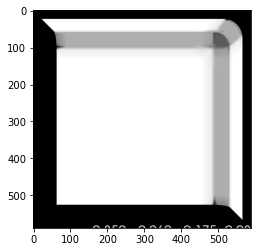

In [52]:
from torchvision.io import read_image
img = read_image("clean\\x-data\\0.png")
print(img.shape)
plt.imshow(  img.permute(1, 2, 0)  )

In [60]:
from torchvision.io import read_image
import PIL
img = read_image("clean\\y-data\\0.png")
print(img.shape)
pil_img =transforms.ToPILImage()(img)

torch.Size([4, 704, 689])


In [8]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        name = f"{idx}.png"
        img_path = os.path.join(self.img_dir, name)
        label_path = os.path.join(self.label_dir, name)
        image = read_image(img_path)
        label = read_image(label_path)
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        return image, label

In [54]:
class MyTransform:
    def __init__(self, img_size):
        self.img_size = (img_size, img_size)

    def __call__(self, x):
        resized_img = transforms.Resize(size=self.img_size)(x)
        return transforms.functional.to_grayscale(resized_img, num_output_channels=1)

In [74]:
class MyTransform:
    def __init__(self, img_size):
        self.img_size = (img_size, img_size)

    def __call__(self, x):
        resized_img = transforms.Resize(size=self.img_size)(x)
        print(resized_img.shape)
        pil_img =transforms.ToPILImage()(resized_img)
        gray_img = transforms.functional.to_grayscale(pil_img, num_output_channels=1)
        return transforms.ToTensor()(gray_img) 

In [75]:
input_test = torch.rand(3, 256, 256)
test = MyTransform(IMG_SIZE)
test(input_test).shape

torch.Size([3, 128, 128])


torch.Size([1, 128, 128])

In [39]:
dset = CustomImageDataset(DATA_PATH_X, DATA_PATH_Y, transform=MyTransform(IMG_SIZE))
dls =  torch.utils.data.DataLoader(dset, batch_size=BATCH_SIZE)

Shape of X [N, C, H, W]: torch.Size([4, 3, 128, 128])
Shape of y: torch.Size([4, 4, 128, 128]) torch.uint8
torch.Size([4, 128, 128])


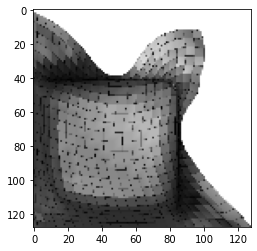

In [48]:
for X, y in dls:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(y[0].shape)
    plt.imshow(  y[0].permute(1, 2, 0)  )
    break

In [4]:
def open_image(fname, size=IMG_SIZE):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    gray_img = PIL.ImageOps.grayscale(img)
    return torch.Tensor(np.array(gray_img))

def label_func(fname):
    path_y = "clean/y-data/"
    base_name_y = os.path.basename(fname)
    fname_y = os.path.join(path_y, base_name_y)
    return open_image(fname_y)

In [5]:
dblock = DataBlock(
    blocks=(ImageBlock, ImageBlock),
    get_items=get_image_files,
    get_x = open_image,
    get_y = label_func,
    )

In [6]:
dls = dblock.dataloaders(
                    DATA_PATH_X, valid_pct=0.2, seed=11, bs=BATCH_SIZE, 
                    batch_tfms=[ 
                    Normalize.from_stats(*imagenet_stats)]
                    )

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


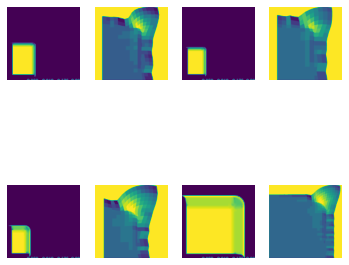

In [7]:
dls.show_batch(figsize=(6,6))

## Model

In [14]:
class LSNet(torch.nn.Module):
    def __init__(self):
        # call the parent constructor
        super(LSNet, self).__init__()
        self.conv_part = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(16, 32, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.deconv_part = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 32, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.ConvTranspose2d(16, 1, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(size=IMG_SIZE, mode='bilinear'),
        )
    def forward(self, x):
        x = self.conv_part(x)
        x = self.deconv_part(x)
        return x

In [15]:
model = LSNet()

In [16]:
input_test = torch.rand(20, 1, 128, 128)
print(input_test.shape)
model(input_test).shape

torch.Size([20, 1, 128, 128])


torch.Size([20, 1, 128, 128])

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")